## Read and Explore data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
train_data = pd.read_csv('./data/train.csv')
train_data.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [3]:
# Separate the type variable into different columns
def create_new_columns(column):
    unique_col_values = np.unique(column)
    new_values = [[1 if a==True else 0 for a in column == u] for u in unique_col_values]
    col_names = [f'Type_{u}' for u in unique_col_values]
    new_df = pd.DataFrame(dict(zip(col_names, new_values)))
    return new_df  # Modify this as needed

# Apply the function to create new columns
df = train_data.join(create_new_columns(train_data.loc[:,'Type']))
df.drop(['Type','id', 'Product ID'],axis=1,inplace=True)
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,0,1,0
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,0,0,1
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,0,1,0
3,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,0,1,0
4,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,0,0,1


#### Explore distribution of dummy variables

In [4]:
# List binary variable names
var_names = ['TWF','HDF','PWF','OSF','RNF', 'Machine failure']
outcome_name = 'Machine failure'

# Choose if plot plot and print values
plot = False
print_values = True

if plot:
    # Create a figure and axis
    fig, axes = plt.subplots(3,2)
    for ax,var_name in zip(axes.flatten(), var_names):
        var_values = np.unique(train_data[var_name])
        dist_arr = [train_data[train_data[var_name] == var_value].shape[0]/train_data.shape[0] for var_value in var_values]
        cmap = get_cmap('RdYlGn', len(dist_arr))
        # Plot a bar chart with automatically selected colors
        ax.set(xticks = var_values)
        ax.set_title(f'{var_name} distribution')
        ax.bar(var_values, height = dist_arr, width = 0.3, color=[cmap(i) for i in range(len(dist_arr))])

if print_values:
    for var_name in var_names:
        var_values = np.unique(train_data[var_name])
        dist_arr = [train_data[train_data[var_name] == var_value].shape[0]/train_data.shape[0] for var_value in var_values]
        print({var_name:dict(zip(var_values,dist_arr))})

{'TWF': {0: 0.9984460781798591, 1: 0.0015539218201408792}}
{'HDF': {0: 0.9948398067859473, 1: 0.005160193214052731}}
{'PWF': {0: 0.9976031488906317, 1: 0.002396851109368243}}
{'OSF': {0: 0.9960418972505846, 1: 0.003958102749415447}}
{'RNF': {0: 0.9977424154688519, 1: 0.0022575845311480695}}
{'Machine failure': {0: 0.9842555468412141, 1: 0.01574445315878589}}


#### Look at feature distribution for the continuous variables

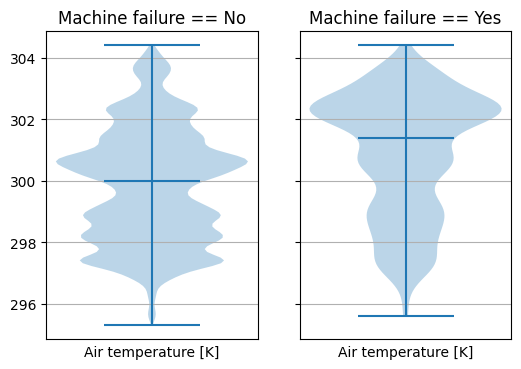

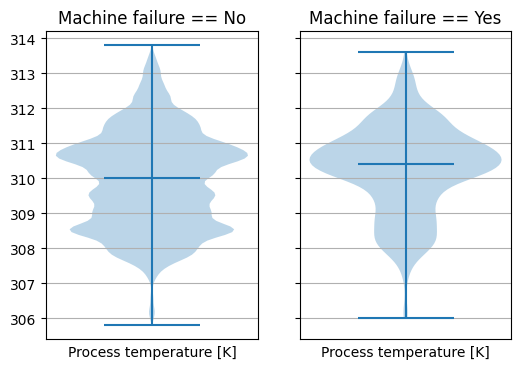

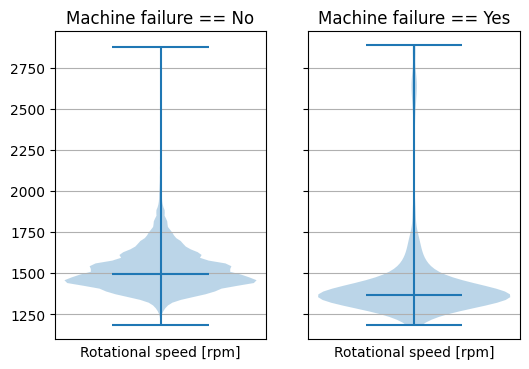

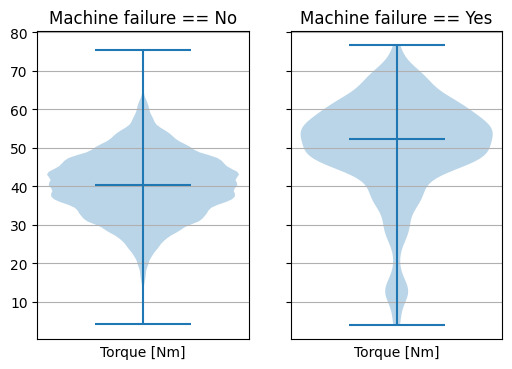

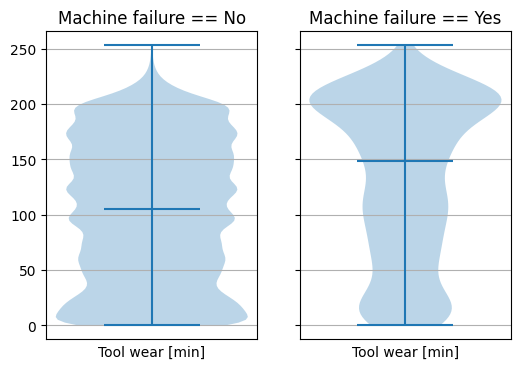

In [5]:
# Select only continuous variables
mf_no = df[df['Machine failure'] == 0].iloc[:,:5]
mf_yes = df[df['Machine failure'] == 1].iloc[:,:5]

# Plot violin plot for each variable according to machine failure
for col in mf_no.columns:
    fig, axs = plt.subplots(1,2,figsize=(6,4), sharey=True)
    axs[0].violinplot(mf_no[col], showmedians = True)
    axs[0].set_title('Machine failure == No')
    axs[1].violinplot(mf_yes[col], showmedians = True)
    axs[1].set_title('Machine failure == Yes')
    for ax in axs:
        ax.yaxis.grid(True)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        ax.set_xlabel(col)
    plt.show()

#### Encode 'Type' column as dummy variable

In [6]:
# Explore some correlations of each predictor with repsonse variable
from sklearn.feature_selection import r_regression
from sklearn.preprocessing import OneHotEncoder

var_names = ['TWF','HDF','PWF','OSF','RNF']
outcome_name = 'Machine failure'

# OneHot Encode Type variable
enc = OneHotEncoder(sparse_output=False, categories='auto')
encoded_type = enc.fit_transform(train_data.loc[:,'Type'].values.reshape(-1,1))

## Train different Support Vector Classifiers

In [7]:
# Import libraries
from sklearn import datasets, svm
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Scale data
scaler = StandardScaler()
for i in range(5):
    df.iloc[:,i] = scaler.fit_transform(df.iloc[:,i].values.reshape(-1,1))

# Prepare data for training
X = df.drop('Machine failure', axis=1).values
y = df['Machine failure'].values

#### SVC with linear kernel

The false positive rate here is arguably the value we would like to go down as it correspond to the error of predicting a machine is working when it's actually not. One way to do this would be to try some search algorithm to find the value of the regularization parameter C that minimized the metric

True Negative rate (specificity):  0.9999031880906457
True positive rate (recall):  0.7635009310986964
False Negative Rate:  0.23649906890130357
False positive rate:  9.681190935428852e-05
Positive Likelihood ratio:  3.2283464566929134


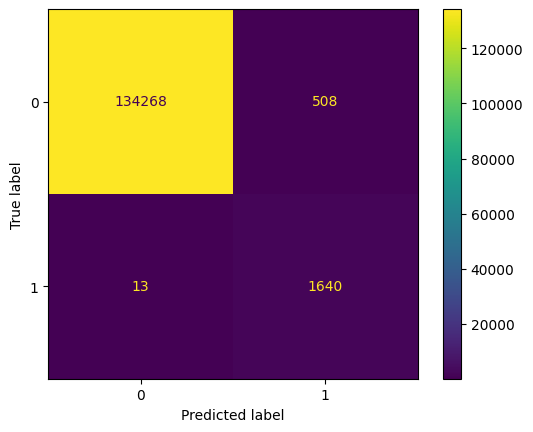

In [77]:
C = 1.0  # SVM regularization parameter
model = svm.SVC(kernel="linear", C=C)
model.fit(X,y)
cm = confusion_matrix(model.predict(X), y)
# Display confusion matrix
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)

In [18]:
# Save model with pickle
import pickle
import os
models_dir = 'models'
# Encoding of the filename is the following: modelname_KernelType_Cvalue_*otherParams.sav
filename = 'SVC_LinKer_1.sav'
# Save file in models
pickle.dump(model, open(os.path.join(models_dir,filename), 'wb'))

#### SVC with linear kernel usign LinearSVC implementation

True Negative rate (specificity):  0.9999031880906457
True positive rate (recall):  0.7635009310986964
False Negative Rate:  0.23649906890130357
False positive rate:  9.681190935428852e-05
Positive Likelihood ratio:  3.2283464566929134


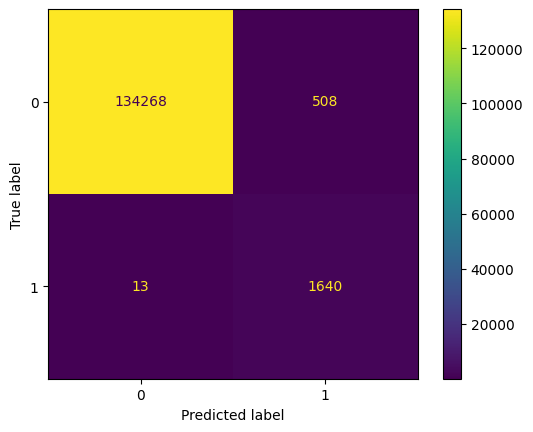

In [76]:
C = 1.0  # SVM regularization parameter
model = svm.LinearSVC(C=C, max_iter=1000, dual="auto")
model.fit(X,y)
cm = confusion_matrix(model.predict(X), y)
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)

In [20]:
# Save model with pickle
filename = 'LinearSVC_maxIter1000_dualAuto.sav'
pickle.dump(model, open(os.path.join(models_dir,filename), 'wb'))

#### SVC with polynomial kernel

True Negative rate (specificity):  0.9999031880906457
True positive rate (recall):  0.7402234636871509
False Negative Rate:  0.25977653631284914
False positive rate:  9.681190935428852e-05
Positive Likelihood ratio:  2.849462365591398


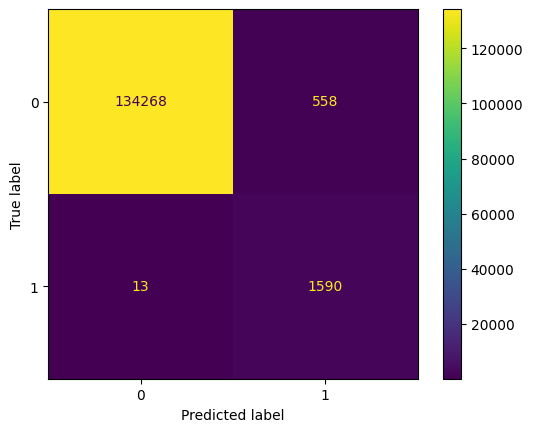

In [78]:
C = 1  # SVM regularization parameter
model = svm.SVC(kernel="poly", degree=3, gamma="auto", C=C)
model.fit(X,y)
cm = confusion_matrix(model.predict(X), y)
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)

In [23]:
# Save model with pickle
filename = 'SVC_PolyKer_1_deg3.sav'
pickle.dump(model, open(os.path.join(models_dir,filename), 'wb'))

#### SVC with radial basis function kernel

True Negative rate (specificity):  0.9999180822305463
True positive rate (recall):  0.7732774674115456
False Negative Rate:  0.22672253258845443
False positive rate:  8.191776945365437e-05
Positive Likelihood ratio:  3.410677618069815


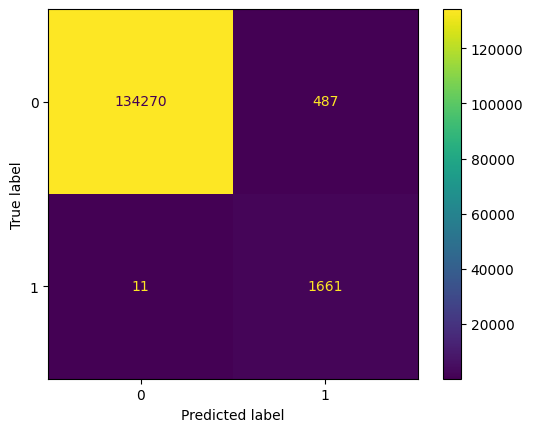

In [79]:
C = 1  # SVM regularization parameter
model = svm.SVC(kernel="rbf", gamma=0.7, C=C)
model.fit(X,y)
cm = confusion_matrix(model.predict(X), y)
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)

In [25]:
# Save model with pickle
filename = 'SVC_RbfKer_1_gamma7e-1.sav'
pickle.dump(model, open(os.path.join(models_dir,filename), 'wb'))

True Negative rate (specificity):  0.9998957410206954
True positive rate (recall):  0.7793296089385475
False Negative Rate:  0.22067039106145248
False positive rate:  0.00010425897930455008
Positive Likelihood ratio:  3.5316455696202533


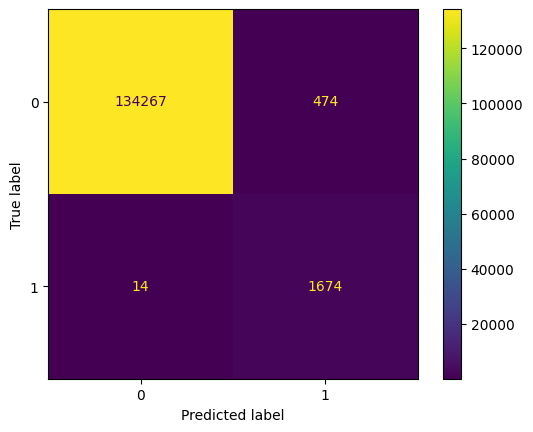

In [80]:
# Try giving more weight to misclassification in loss minimization to same rbf kernel SVC
C = 2  # SVM regularization parameter
model = svm.SVC(kernel="rbf", gamma=0.7, C=C)
model.fit(X,y)
cm = confusion_matrix(model.predict(X), y)
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)

In [81]:
# Save model with pickle
filename = 'SVC_RbfKer_2_gamma7e-1.sav'
pickle.dump(model, open(os.path.join(models_dir,filename), 'wb'))

### Try logistic regression

True Negative rate (specificity):  0.9999031880906457
True positive rate (recall):  0.7611731843575419
False Negative Rate:  0.2388268156424581
False positive rate:  9.681190935428852e-05
Positive Likelihood ratio:  3.1871345029239766


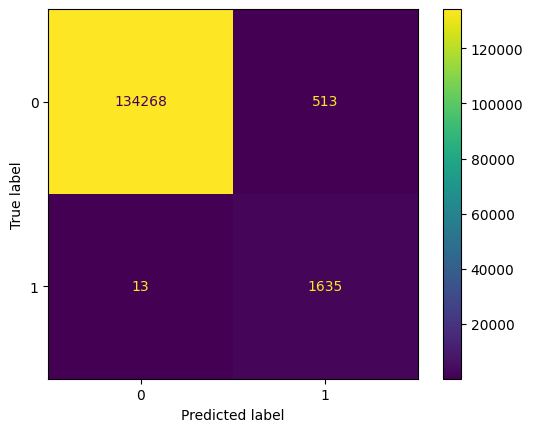

In [75]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X, y)
cm = confusion_matrix(clf.predict(X), y)
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)

### Try some class balancing techniques

True Negative rate (specificity):  0.9669722447702951
True positive rate (recall):  0.8747672253258846
False Negative Rate:  0.12523277467411542
False positive rate:  0.033027755229704914
Positive Likelihood ratio:  6.985130111524164


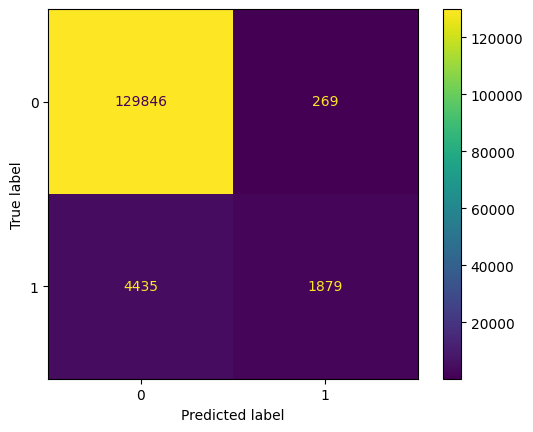

In [74]:
### Try using the unbalancedness ratio to determine the class weight and train the same models
# filter = lambda value: len(df['Machine failure'][df['Machine failure'] == value])
# ratio = filter(1)/filter(0)
# class_weight = {0: ratio, 1: 1-ratio}
# C = 1.0  # SVM regularization parameter
# model = svm.SVC(kernel="rbf", gamma=0.7, C=C, class_weight = class_weight)
# model.fit(X,y)
# cm = confusion_matrix(model.predict(X), y)
# # Display confusion matrix
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)

In [8]:
df.tail()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
136424,0.127386,1.053251,0.069693,-0.335048,1.650769,0,0,0,0,0,0,0,0,1
136425,-1.268781,-1.040358,-0.528565,1.029305,-1.601020,0,0,0,0,0,0,1,0,0
136426,0.342182,1.342025,0.026445,-0.217431,1.713303,0,0,0,0,0,0,0,1,0
136427,0.986567,0.692284,-0.528565,0.699979,-0.975676,0,0,0,0,0,0,0,1,0
136428,-1.590974,-1.329132,0.264307,-0.123338,1.947807,0,0,0,0,0,0,0,1,0


### Decision Trees

Becuase decision trees tend to be biased when prediction classes are imbalanced, it is paramount to apply oversampling, undersampling, or generate synthetic data. Evaluation of Decision Trees will be performed using each of the above methods and comparing results

#### Try with oversampling

The objective of oversampling is to randomly resemple data from the umbalanced class and insert it in our training dataset until the target balance is achieved. A good way to sample is probably to use a uniform distribution for the sampling. 

In [25]:
# Set pseudo-random number generator
np.random.default_rng(seed=123)

filter = lambda value: len(df['Machine failure'][df['Machine failure'] == value])
# Build oversampled dataset
machine_failures = df[df['Machine failure']==1].reset_index().drop('index', axis=1)
oversampled_data = df.copy().values
# Init count 
count = oversampled_data.shape[0]-1
cond = df['Machine failure'] == 1
for i in range(count - cond.sum()):
    oversampled_data = np.vstack((oversampled_data,machine_failures.iloc[int(np.floor(np.random.uniform(0,filter(1)))),:].values))
# oversampled_data.where(oversampled_data[:,5] == 1).sum()

In [17]:
oversampled_data[oversampled_data[:,5] == 0].sum()

130518.55322008797

#### Test result first on linear svm

In [1]:
# Prepare data for training
X = oversampled_data[:,]
y = oversampled_data[:,5]

C = 1.0  # SVM regularization parameter
model = svm.LinearSVC(C=C, max_iter=1000, dual="auto")
model.fit(X,y)
cm = confusion_matrix(model.predict(X), y)
cm_display = ConfusionMatrixDisplay(cm).plot()

TN,TP,FP,FN = cm[0,0],cm[1,1],cm[0,1],cm[1,0]
# Print some metrics alternative to prediction accuracy
print('True Negative rate (specificity): ', TN/(TN+FN))
print('True positive rate (recall): ', TP/(TP+FP))
print('False Negative Rate: ', 1-TP/(TP+FP))
print('False positive rate: ', 1-TN/(TN+FN))
print('Positive Likelihood ratio: ', TP/FP)
